In [1]:
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import math


import cv2
import pandas as pd

from torch import nn 
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F 
from torch.nn import ReLU, Conv2d, Linear, Flatten
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
from datetime import date
from sklearn.metrics import f1_score, accuracy_score
from collections  import Counter

import random



print(tf.__version__)
%config Completer.use_jedi = False

2.6.4


In [2]:
mnist = tf.keras.datasets.mnist
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f"Training Data Shape {x_train.shape}")

print(f"Testing Data Shape {x_test.shape}")

11501568/11490434 [==============================] - 0s 0us/step
Training Data Shape (60000, 28, 28)
Testing Data Shape (10000, 28, 28)


# Display Image

In [4]:
def display_image(data, COLS=4, ROWS=4):
    # iterate over rows     
    for k in range(ROWS):
        # for each row we will set the size of figure
        plt.figure(figsize=(20,5))
        # iterate over all the columns
        for j in range(COLS):
            row = COLS*k + j    
            rand_index=np.random.randint(0,len(data))
            img_sample= data[rand_index]
            plt.subplot(1,COLS,j+1)
            
            plt.axis('off')
            # display image
            
            plt.imshow(img_sample)
        plt.show()
        

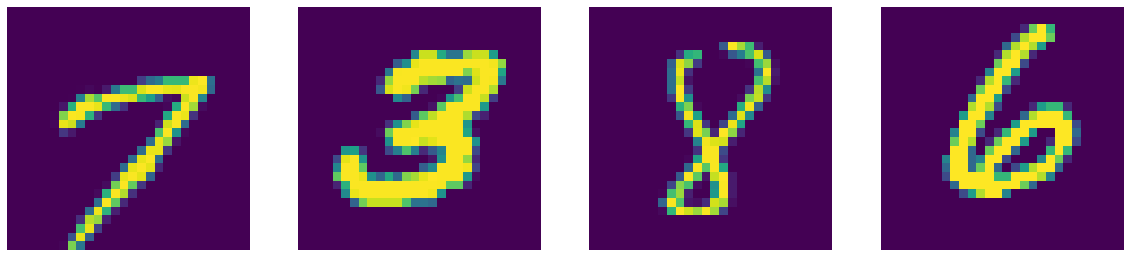

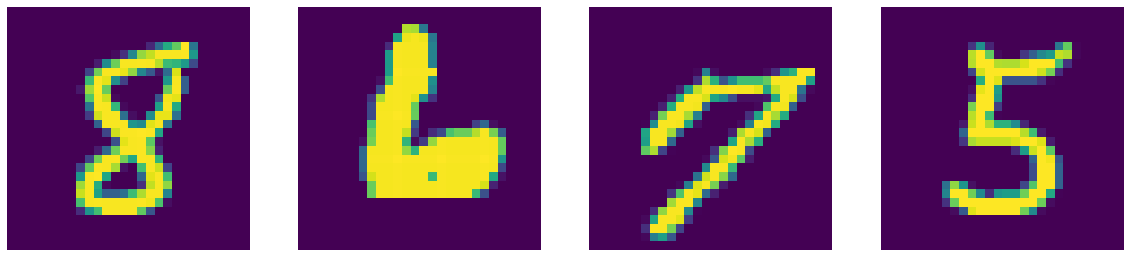

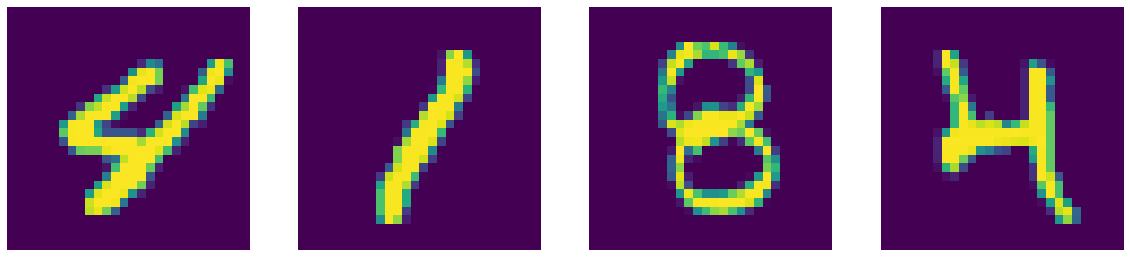

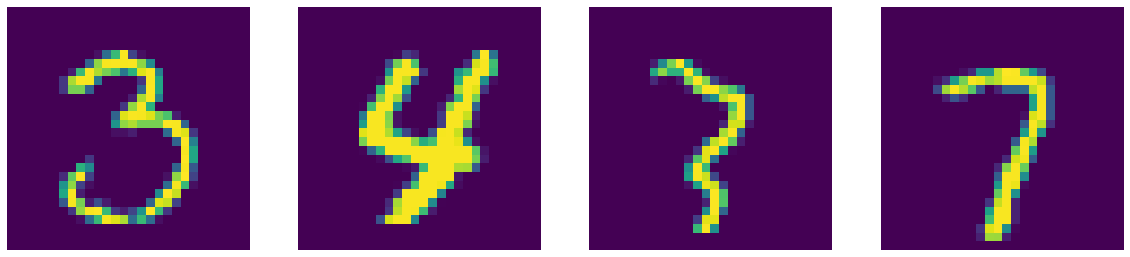

In [5]:
display_image(x_train)


# Setup Dataset


In [6]:
# channel first ordering
x_train = x_train.reshape(-1, 1,28, 28)
x_test = x_test.reshape(-1, 1,28, 28)


# convert to float 
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0





x_train = torch.Tensor(x_train) # transform to torch tensor
y_train = torch.tensor(y_train).long()

x_test = torch.Tensor(x_test) # transform to torch tensor
y_test = torch.tensor(y_test).long()


train_dataset = TensorDataset(x_train,y_train) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size=64) # create your dataloader


valid_dataset = TensorDataset(x_test,y_test) # create your datset
valid_dataloader = DataLoader(valid_dataset,batch_size=64) # create your dataloader

# Model

In [7]:
class ArcFaceLoss(nn.Module):
    def __init__(self,margin = 0.4, scale=30, out_classes=10, emb_size =3,  easy_margin=False, ls_eps=0.0):
        super(ArcFaceLoss, self).__init__()
#         print("init",margin)
        self.W = nn.Parameter(torch.FloatTensor(out_classes, emb_size))
        # initialize weight 
        nn.init.xavier_uniform_(self.W)
        self.s=scale
        self.m = margin
        self.out_features = out_classes
        self.emb_size=emb_size
        self.easy_margin=easy_margin
        self.ls_eps=ls_eps
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin
        
        
    def forward(self, x,y):
#         print("ArcFace Forward pass", x.shape, y.shape)
        # normalize features and normalize weight vectors
        feature_norm =F.normalize(x)
        weight_norm = F.normalize(self.W)
        # cosine = X.W = ||X|| .||W|| . cos(theta) 
        # if X and W are normalize then dot product X, W = will be cos theta
        
        # Get cosine similarity by multiplication 
        # we have normalized features and weight vectors and we don't have bias in
        # in weight vector so weight * features = cosine(features, weights)
        cosine = F.linear(feature_norm,weight_norm)
        cosine = cosine.clip(-1+1e-7, 1-1e-7) 
        
        # Step 3:
        arcosine = cosine.arccos()
        # Step 4:
        arcosine += F.one_hot(y, num_classes = self.out_features) * self.m
        # Step 5:
        cosine2 = arcosine.cos()
        # Step 6:
        return cosine2
        
        

        
        
        
        

In [8]:
class MnistClassfier(nn.Module):
    def __init__(self, lossType='softmax', emb_size=3, out_classes=10):
        super(MnistClassfier, self).__init__()
        self.lossType = lossType
        self.emb_size=emb_size
#         torch.nn.Conv2d
        self.conv1 = Conv2d(1,64, kernel_size=3, padding='same')
        self.activation = ReLU()
        self.conv2 = Conv2d(64,128,kernel_size=3,padding='same')
        self.flat = Flatten()
        self.out_classes=out_classes
        self.dense1 = nn.LazyLinear(emb_size)
        if lossType=='softmax':
            self.final = nn.Linear(emb_size, out_classes)
        else:
            self.final = ArcFaceLoss()
        
        
    def get_embs(self, x):
        x = self.conv1(x)
#         print("::::", x.shape)
        x = self.activation(x)
#         print("2", x.shape)
        x= self.conv2(x)
#         print("3", x.shape)
        x = self.activation(x)
#         print("4", x.shape)
        x= self.flat(x)
#         print("44", x.shape)
        x=self.dense1(x)
#         print("44r", x.shape)
        return x
        
    def forward(self, x,y):
#         print("Shape Forward", x.shape)
#         print("1:", x.shape)
        
        x = self.get_embs(x)
#         print("Shape Forward", x.shape)
#         print("$$$$$$44",x.shape)
        if self.lossType=='softmax':
            x = self.final(x)
#             print("returning",x.shape)
            return x
        else:
#             print("else")
            x = self.final(x,y)
            
            return x
        

In [9]:
def training_single_epoch(epoch_num, model,train_dataloader, loss_criteria= None, optimizer=None):
    avgloss =0.0
    # put model on trainng
    model.train()
    print("Loss:",model.lossType)
    tq = tqdm(enumerate(train_dataloader), total=len(train_dataloader)) 
    y_true=[]
    y_pred=[]
    
    
    for idx, data in tq:
        x, y = data
        x = x.to(device)
        y = y.to(device)
        # zero out gradient
        optimizer.zero_grad()
        # forward pass
        out= model(x, y)
        
#         loss = loss_criteria(out,torch.tensor(y).long())
        loss = loss_criteria(out,y)
        # backward pass
        loss.backward()
        # step
        optimizer.step()
        
        predictions = torch.argmax(out, 1)
        y_true.extend(y.detach().cpu().numpy())
        y_pred.extend(predictions.detach().cpu().numpy())
        # avg loss
        avgloss += loss.item() 

        tq.set_postfix({'loss' : '%.6f' %float(avgloss/(idx+1))})
        
    # f1score
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Training Epoch {epoch_num} => F1 Score {f1}")
    
    return  avgloss / len(train_dataloader),f1
        

In [10]:
def Validating_single_epoch(epoch_num, model,valid_dataloader, loss_criteria= None):
    avgloss =0.0
    # put model on Evalution
    model.eval()
    
    tq = tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)) 
    y_true=[]
    y_pred=[]
    with torch.no_grad():
    
        for idx, data in tq:
            x, y = data
            x = x.to(device)
            y = y.to(device)

            # forward pass
            out = model(x, y)
            loss = loss_criteria(out,y)
    #         loss = loss_criteria(out,torch.tensor(y).long())

            predictions = torch.argmax(out, 1)
            y_true.extend(y.detach().cpu().numpy())
            y_pred.extend(predictions.detach().cpu().numpy())
            # avg loss
            avgloss += loss.item() 

            tq.set_postfix({'loss' : '%.6f' %float(avgloss/(idx+1))})

    # f1score
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Validation Epoch {epoch_num} => F1 Score {f1}")
    
    return  avgloss / len(valid_dataloader),f1
        

In [11]:


def run_training(epochs,model, loss, optimizer, history=None):
    for epoch in range(epochs):
        # training single epoch
        train_avgloss, train_f1 = training_single_epoch(epoch, model,train_dataloader, loss_criteria= loss, optimizer=optimizer)
    
        valid_avgloss, valid_f1 = Validating_single_epoch(epoch, model,valid_dataloader, loss_criteria= loss)

        print("Epoch : {} avg f1 {}".format(epoch+1,train_f1))
        
        history['val_loss'].append(valid_avgloss)
        history['train_loss'].append(train_avgloss)
        history['valid_f1'].append(valid_f1)
        history['train_f1'].append(train_f1)
        
    return model, history
    

# Training Softmax Loss

In [12]:
emb_size=3
n_classes=10
epochs=5

model = MnistClassfier(lossType='softmax')
model.to(device)

loss_criteria = nn.CrossEntropyLoss()
loss_criteria.to(device)

# define optimzer
optimizer = torch.optim.Adam(model.parameters(),lr= 0.001)

history={ 'val_loss':[],
         'train_loss':[],
         'valid_f1':[], 
         'train_f1':[]
        }
model, history= run_training(epochs,model, loss_criteria, optimizer, history=history)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loss: softmax


100%|██████████| 938/938 [00:13<00:00, 68.77it/s, loss=0.496895] 


Training Epoch 0 => F1 Score 0.8535249614604827


100%|██████████| 157/157 [00:00<00:00, 239.40it/s, loss=0.280143]


Validation Epoch 0 => F1 Score 0.9164638018732602
Epoch : 1 avg f1 0.8535249614604827
Loss: softmax


100%|██████████| 938/938 [00:07<00:00, 133.05it/s, loss=0.242606]


Training Epoch 1 => F1 Score 0.9309900071561735


100%|██████████| 157/157 [00:00<00:00, 221.05it/s, loss=0.209639]


Validation Epoch 1 => F1 Score 0.9360294166818178
Epoch : 2 avg f1 0.9309900071561735
Loss: softmax


100%|██████████| 938/938 [00:06<00:00, 134.55it/s, loss=0.192777]


Training Epoch 2 => F1 Score 0.9455313928400827


100%|██████████| 157/157 [00:00<00:00, 238.96it/s, loss=0.196437]


Validation Epoch 2 => F1 Score 0.9388507821030194
Epoch : 3 avg f1 0.9455313928400827
Loss: softmax


100%|██████████| 938/938 [00:07<00:00, 127.16it/s, loss=0.162270]


Training Epoch 3 => F1 Score 0.95394808877006


100%|██████████| 157/157 [00:00<00:00, 238.59it/s, loss=0.174013]


Validation Epoch 3 => F1 Score 0.948605682351273
Epoch : 4 avg f1 0.95394808877006
Loss: softmax


100%|██████████| 938/938 [00:07<00:00, 132.89it/s, loss=0.137779]


Training Epoch 4 => F1 Score 0.9601214283556218


100%|██████████| 157/157 [00:00<00:00, 228.93it/s, loss=0.170020]


Validation Epoch 4 => F1 Score 0.9489884219154485
Epoch : 5 avg f1 0.9601214283556218


# Train ArcFace Loss

In [13]:
emb_size=3
n_classes=10
epochs=15

arcfacemodel = MnistClassfier(lossType='ArcFace')
arcfacemodel.to(device)

loss_criteria = nn.CrossEntropyLoss()
loss_criteria.to(device)

# define optimzer
optimizer = torch.optim.Adam(arcfacemodel.parameters(),lr= 0.001)

arcface_history={ 'val_loss':[],
         'train_loss':[],
         'valid_f1':[], 
         'train_f1':[]
        }
arcfacemodel, arcface_history= run_training(epochs,arcfacemodel, loss_criteria, optimizer, history=arcface_history)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 129.04it/s, loss=1.747677]


Training Epoch 0 => F1 Score 0.5583998933457445


100%|██████████| 157/157 [00:00<00:00, 222.98it/s, loss=1.643971]


Validation Epoch 0 => F1 Score 0.7878011987261562
Epoch : 1 avg f1 0.5583998933457445
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 131.15it/s, loss=1.622316]


Training Epoch 1 => F1 Score 0.8401416979351065


100%|██████████| 157/157 [00:00<00:00, 241.90it/s, loss=1.619741]


Validation Epoch 1 => F1 Score 0.8544462987903827
Epoch : 2 avg f1 0.8401416979351065
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 118.55it/s, loss=1.603325]


Training Epoch 2 => F1 Score 0.8973242804061702


100%|██████████| 157/157 [00:00<00:00, 228.94it/s, loss=1.606925]


Validation Epoch 2 => F1 Score 0.9014154696998684
Epoch : 3 avg f1 0.8973242804061702
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 126.92it/s, loss=1.592189]


Training Epoch 3 => F1 Score 0.9300172249054108


100%|██████████| 157/157 [00:00<00:00, 233.63it/s, loss=1.599324]


Validation Epoch 3 => F1 Score 0.9225195155976478
Epoch : 4 avg f1 0.9300172249054108
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 125.47it/s, loss=1.584276]


Training Epoch 4 => F1 Score 0.9460715345927365


100%|██████████| 157/157 [00:00<00:00, 225.78it/s, loss=1.595109]


Validation Epoch 4 => F1 Score 0.9312541158619994
Epoch : 5 avg f1 0.9460715345927365
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 129.55it/s, loss=1.579289]


Training Epoch 5 => F1 Score 0.9549517531223314


100%|██████████| 157/157 [00:00<00:00, 227.50it/s, loss=1.591620]


Validation Epoch 5 => F1 Score 0.9374289466198859
Epoch : 6 avg f1 0.9549517531223314
Loss: ArcFace


100%|██████████| 938/938 [00:08<00:00, 115.10it/s, loss=1.575161]


Training Epoch 6 => F1 Score 0.9619782972727885


100%|██████████| 157/157 [00:00<00:00, 224.66it/s, loss=1.589149]


Validation Epoch 6 => F1 Score 0.9391108342556137
Epoch : 7 avg f1 0.9619782972727885
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 127.91it/s, loss=1.572076]


Training Epoch 7 => F1 Score 0.9678341057655775


100%|██████████| 157/157 [00:00<00:00, 231.59it/s, loss=1.588137]


Validation Epoch 7 => F1 Score 0.9406081905869839
Epoch : 8 avg f1 0.9678341057655775
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 125.13it/s, loss=1.569374]


Training Epoch 8 => F1 Score 0.9716864364048534


100%|██████████| 157/157 [00:00<00:00, 231.51it/s, loss=1.588265]


Validation Epoch 8 => F1 Score 0.9403307234694255
Epoch : 9 avg f1 0.9716864364048534
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 131.66it/s, loss=1.567335]


Training Epoch 9 => F1 Score 0.9745022420088404


100%|██████████| 157/157 [00:00<00:00, 162.64it/s, loss=1.588073]


Validation Epoch 9 => F1 Score 0.940962830170256
Epoch : 10 avg f1 0.9745022420088404
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 124.95it/s, loss=1.565277]


Training Epoch 10 => F1 Score 0.9777921475534388


100%|██████████| 157/157 [00:00<00:00, 232.60it/s, loss=1.588370]


Validation Epoch 10 => F1 Score 0.9399441756585523
Epoch : 11 avg f1 0.9777921475534388
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 126.19it/s, loss=1.563621]


Training Epoch 11 => F1 Score 0.9794006187561891


100%|██████████| 157/157 [00:00<00:00, 228.28it/s, loss=1.589927]


Validation Epoch 11 => F1 Score 0.9407646060577429
Epoch : 12 avg f1 0.9794006187561891
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 126.02it/s, loss=1.562296]


Training Epoch 12 => F1 Score 0.981696271439475


100%|██████████| 157/157 [00:00<00:00, 235.34it/s, loss=1.588738]


Validation Epoch 12 => F1 Score 0.9399602678238687
Epoch : 13 avg f1 0.981696271439475
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 121.38it/s, loss=1.560918]


Training Epoch 13 => F1 Score 0.9830456275704005


100%|██████████| 157/157 [00:00<00:00, 227.48it/s, loss=1.589550]


Validation Epoch 13 => F1 Score 0.9415906584730387
Epoch : 14 avg f1 0.9830456275704005
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 125.93it/s, loss=1.559918]


Training Epoch 14 => F1 Score 0.9849612520647602


100%|██████████| 157/157 [00:00<00:00, 227.09it/s, loss=1.590590]


Validation Epoch 14 => F1 Score 0.9396243021610451
Epoch : 15 avg f1 0.9849612520647602


# Visualize Embeddings

In [14]:
def getEmbeddings(model, dl):
    model.eval()
    
    tq = enumerate(valid_dataloader)
    embeddings = []
    labels = []
    with torch.no_grad():
        for idx,data in enumerate(dl):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            embeddings.append(model.get_embs(x))
            labels.append(y)
    embeddings = torch.cat(embeddings)
#     embeddings = embeddings / torch.linalg.norm(embeddings,dim=1)[:,None]
    embeddings = embeddings / embeddings.norm(p=2,dim=1)[:,None]
    labels = torch.cat(labels)
    return embeddings,labels

# Get Softmax Embeddings

In [15]:
softmax_emb, softmax_ys = getEmbeddings(model, valid_dataloader)


# Get ArcFace Embeddings

In [16]:
arcface_emb, arcface_ys = getEmbeddings(arcfacemodel, valid_dataloader)


In [17]:
def plot_embs(embeddings, ys, ax):
    # scatter plot of all the labels with different class and plot their embeddings
    # in 3d space
    colors = ['blue','orange','green','purple','red','brown','pink','gray','olive','cyan']
    for k in range(10):
        # if k ==1 , embeddings[ys==k] will get embddings for all the image input
        # with label = 1
        e = embeddings[ys==k].cpu()
        # plot in 3d
        ax.scatter(e[:,0], e[:,1], e[:,2], s=4, alpha=.2, color=colors[k])   

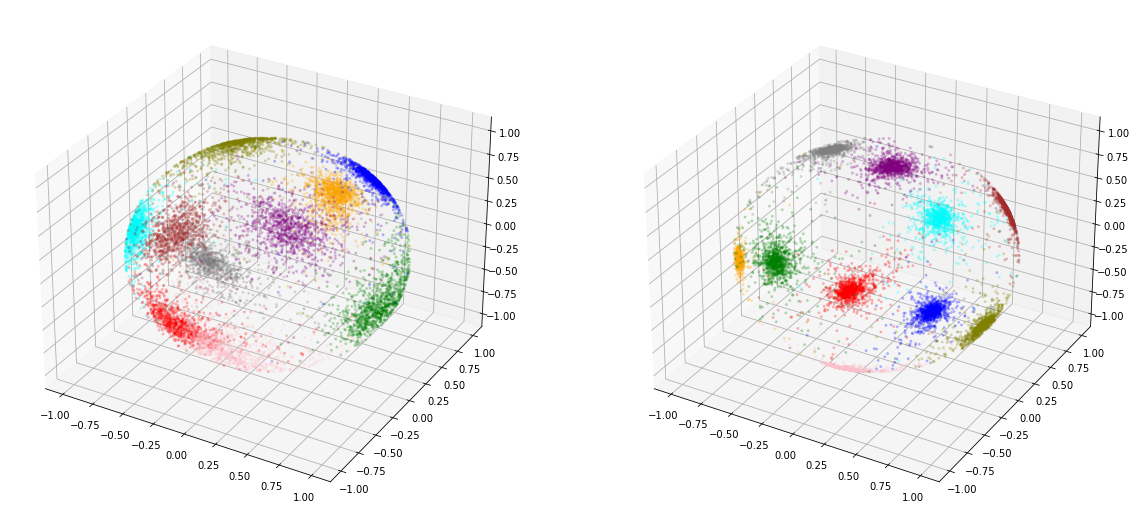

In [18]:
_,(ax1,ax2)=plt.subplots(1,2, figsize=(20,10), subplot_kw={'projection':'3d'})
# plot softmax embeddings
plot_embs(softmax_emb, softmax_ys, ax1)
# plot arcface embeddings
plot_embs(arcface_emb, arcface_ys, ax2)


plt.show()